In [1]:
# !kaggle datasets download -d humairmunir/gender-recognizer

In [2]:
# !unzip /content/gender-recognizer.zip

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import image_dataset_from_directory
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3 # Import VGG16, ResNet50, and InceptionV3 from keras.applications
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# Directories
base_dir = '/content/dataset'
men_dir = os.path.join(base_dir, 'MEN')
women_dir = os.path.join(base_dir, 'WOMAN')

In [5]:
# Function to load images and labels
def load_images_and_labels(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (128, 128)) # Resize for consistency
            images.append(img)
            labels.append(label)
    return images, labels

# Load images
men_images, men_labels = load_images_and_labels(men_dir, 0)
women_images, women_labels = load_images_and_labels(women_dir, 1)

In [6]:
# Combine data
images = men_images + women_images
labels = men_labels + women_labels

<Axes: ylabel='count'>

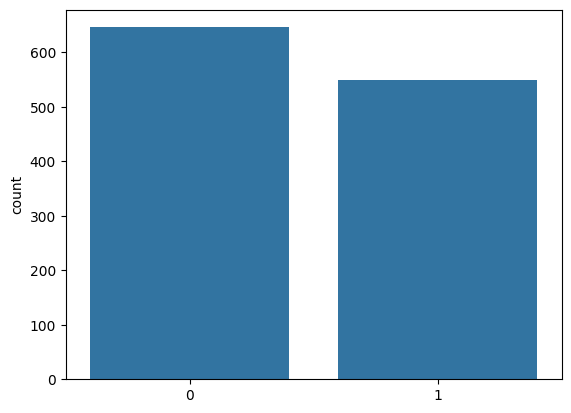

In [7]:
sns.countplot(x=labels)

In [8]:
images=np.array(images)
labels=np.array(labels)

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [10]:
model=Sequential()
resnet=ResNet50(weights="imagenet",include_top=False,input_shape=(128,128,3))
resnet.trainable=False
model.add(resnet)
model.add(Conv2D(32,kernel_size=(3,3),activation="relu",kernel_regularizer=regularizers.l1(0.01)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Dense(64,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64,activation="relu"))

model.add(Flatten())

model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 32)          589856    
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 1, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 1, 1, 32)          0         
                                                                 
 dense (Dense)               (None, 1, 1, 64)          2112      
                                                                 
 dense_1 (Dense)             (None, 1, 1, 128)         8320      
                                                      

In [15]:
opt=Adam(learning_rate=0.00001)
model.compile(optimizer=opt,loss="binary_crossentropy",metrics=["accuracy"])
collback=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)
history=model.fit(x_train,y_train,epochs=50,validation_data=(x_test,y_test),callbacks=[collback])


Epoch 1/50
30/30 [==============================] - 11s 179ms/step - loss: 0.4410 - accuracy: 0.9728 - val_loss: 0.4411 - val_accuracy: 0.9540
Epoch 2/50
30/30 [==============================] - 3s 97ms/step - loss: 0.3231 - accuracy: 0.9812 - val_loss: 0.3902 - val_accuracy: 0.9540
Epoch 3/50
30/30 [==============================] - 3s 108ms/step - loss: 0.2877 - accuracy: 0.9854 - val_loss: 0.3704 - val_accuracy: 0.9540
Epoch 4/50
30/30 [==============================] - 3s 94ms/step - loss: 0.2805 - accuracy: 0.9770 - val_loss: 0.3572 - val_accuracy: 0.9540
Epoch 5/50
30/30 [==============================] - 3s 103ms/step - loss: 0.2633 - accuracy: 0.9822 - val_loss: 0.3524 - val_accuracy: 0.9540
Epoch 6/50
30/30 [==============================] - 4s 118ms/step - loss: 0.2559 - accuracy: 0.9864 - val_loss: 0.3425 - val_accuracy: 0.9582
Epoch 7/50
30/30 [==============================] - 3s 106ms/step - loss: 0.2538 - accuracy: 0.9854 - val_loss: 0.3414 - val_accuracy: 0.9540
Epoch 8

In [13]:
#Reprot
y_pred=model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int) # Convert probabilities to binary predictions
print(classification_report(y_test,y_pred_binary))

8/8 [==============================] - 1s 118ms/step
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       134
           1       0.92      0.97      0.94       105

    accuracy                           0.95       239
   macro avg       0.95      0.95      0.95       239
weighted avg       0.95      0.95      0.95       239



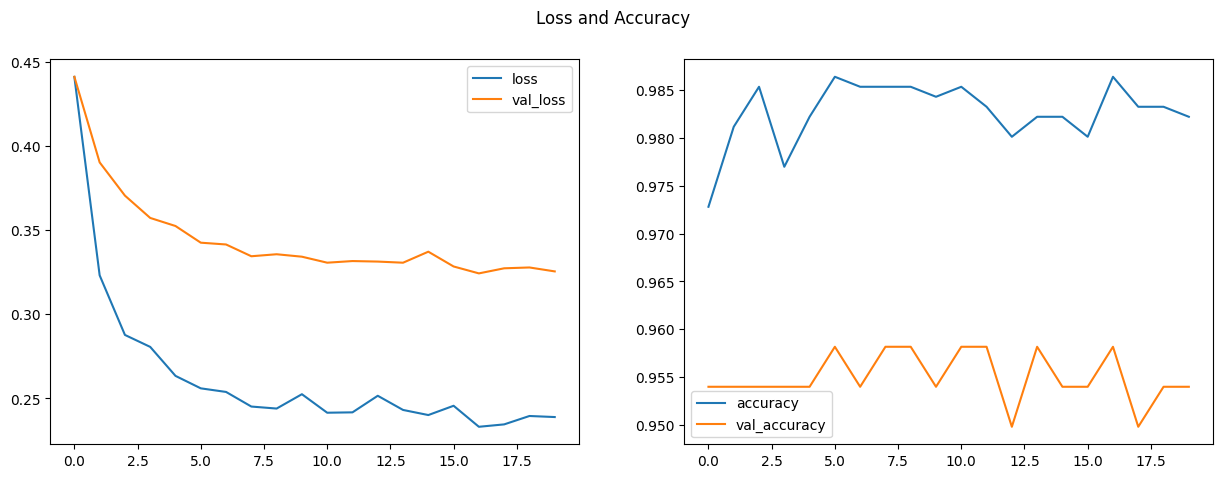

In [19]:
#PLot loss and accuracy
fig, asix = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Loss and Accuracy")
asix[0].plot(history.history["loss"],label="loss")
asix[0].plot(history.history["val_loss"],label="val_loss")
asix[0].legend()
asix[1].plot(history.history["accuracy"],label="accuracy")
asix[1].plot(history.history["val_accuracy"],label="val_accuracy")
asix[1].legend()
plt.show()

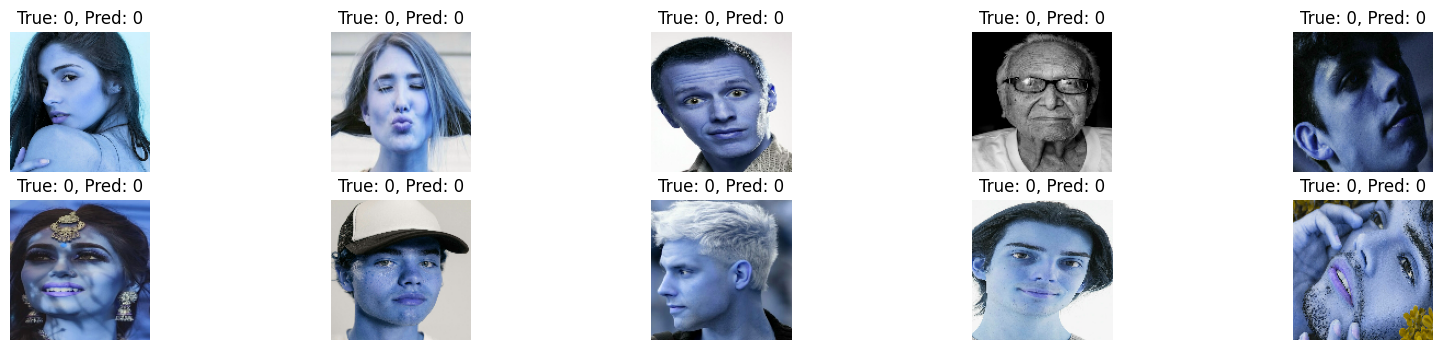

In [26]:
# Show 10 sample predictions
def plot_sample_predictions(X, y_true, y_pred, num_samples=10):
    indices = np.random.choice(range(len(X)), num_samples, replace=False)
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(indices):
        plt.subplot(2, num_samples // 2, i + 1)
        plt.imshow(X[idx])
        plt.title(f"True: {np.argmax(y_true[idx])}, Pred: {np.argmax(y_pred[idx])}")
        plt.axis('off')
    plt.show()

plot_sample_predictions(x_test, y_test, y_pred)



In [25]:
model.save("face_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
